In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from time import time
%matplotlib inline

#### Load data

In [2]:
# load csv files
train_df = pd.read_csv("train.csv")
profiles_df = pd.read_csv("profiles.csv")
artists_df = pd.read_csv("artists.csv")
artists_with_genres_df = pd.read_csv("artists_with_genres.csv")
user_median_df = pd.read_csv("user_median.csv")
global_median_df = pd.read_csv("global_median.csv")

#### Calculate mean ages per gender, country combination

In [3]:
# calculate mean age per user
mean_age = profiles_df[~profiles_df['age'].isnull()]["age"].mean()

###################################################################### 

# calculate mean age per men
males_only_df = profiles_df[profiles_df["sex"]=='m']
mean_male_age = males_only_df[~males_only_df['sex'].isnull()]["age"].mean()

###################################################################### 

# calculate mean age per women
females_only_df = profiles_df[profiles_df["sex"]=='f']
mean_female_age = females_only_df[~females_only_df['sex'].isnull()]["age"].mean()

###################################################################### 

# get list of unique countries
countries = profiles_df["country"].unique()

# calculate mean age per country
mean_country_age = {}
for country in countries:
    tmp_df = profiles_df[profiles_df["country"]==str(country)]
    mean_country_age[str(country)] = tmp_df["age"].mean()

###################################################################### 
    
# calculate mean age per male per country
mean_country_male_age = {}
for country in countries:
    tmp_df0 = profiles_df[profiles_df["sex"]=='m']
    tmp_df1 = tmp_df0[profiles_df["country"]==str(country)]
    mean_country_male_age[str(country)] = tmp_df1["age"].mean()

###################################################################### 

# calculate mean age per female per country
mean_country_female_age = {}
for country in countries:
    tmp_df0 = profiles_df[profiles_df["sex"]=='f']
    tmp_df1 = tmp_df0[profiles_df["country"]==str(country)]
    mean_country_female_age[str(country)] = tmp_df1["age"].mean()

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


#### Create training dataframe with indicator variable columns and missing age values filled in

In [4]:
# initialize training df
training_df = profiles_df

###################################################################### 

# create sex indicators
training_df["male"] = 0
training_df["female"] = 0
training_df["sex_missing"] = 0
training_df.loc[training_df["sex"] =='m', "male"] = 1
training_df.loc[training_df["sex"] =='f', "female"] = 1
training_df.loc[training_df["sex"].isnull(), "sex_missing"] = 1

######################################################################  

# create age indicators
training_df["age_missing"] = 0
training_df.loc[training_df["age"].isnull(),"age_missing"] = 1

# fill in mean age: has no gender or country
training_df.loc[training_df["age_missing"] == 1, "age"] = mean_age

# fill in mean age: has gender, no country
#males
condition = (training_df["sex"] =='m') & (training_df["country"].isnull()) & (training_df["age_missing"] == 1)
training_df.loc[condition, "age"] = mean_male_age
# females
condition = (training_df["sex"] =='f') & (training_df["country"].isnull()) & (training_df["age_missing"] == 1)
training_df.loc[condition, "age"] = mean_female_age

# fill in mean age: has country, no gender
#loop over countries
for country in countries:
    condition = (training_df["country"] == country) & (training_df["age_missing"] == 1) & (training_df["sex_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_age[country]

# fill in mean age: has gender and country
# loop over countries
for country in countries:
    # males
    condition = (training_df["country"] == country) & (training_df["sex"] == 'm') & (training_df["age_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_male_age[country]
    # females
    condition = (training_df["country"] == country) & (training_df["sex"] == 'f') & (training_df["age_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_female_age[country]

###################################################################### 
    
# create country indicators
training_df["country_missing"] = 0
training_df.loc[training_df["country"].isnull(), "country_missing"] = 1
# loop over countries
for country in countries:
    # assign 1 if in that country
    training_df.loc[training_df["country"] == country, country] = 1
    # assign 0 otherwise
    training_df.loc[training_df["country"] != country, country] = 0

#### Transfer plays per artist data from train df to our training df. one column per artist

In [5]:
## Initialize all artist columns to 0
artists = train_df["artist"].unique()
for artist in artists:
    training_df[artist]=0
 
######################################################################

# create helper function to keep track of loop progress and est. time remaining
def progress(step, steps, t0):
    for i in range(1,10):
        if (step == (steps/10)*i):
            percent_complete = int(100*((steps/10)*i)/steps)
            seconds_remaining = int(((time()-t0)/i)*(10-i))
            print "\r" + str(percent_complete) + "% complete " + str(seconds_remaining) + " seconds remaining",

######################################################################

# set index to user for faster computation
training_df = training_df.set_index("user")
counter = 0
t0 = time()

#########################
# WARNING: TAKES ~80Min #
#########################

# loop through each row in train_df and plug play value into training_df
for index, row in train_df.set_index("user").iterrows():
    training_df.loc[index, row[0]] = row[1] #index = user id, row[0] = artist id, row[1] = plays
    counter += 1
    progress(counter, len(train_df), t0) # print progress (every 10ppts)

89% complete 354 seconds remaining


##### Uncomment below as needed to load training

In [4]:
# training_df.to_csv("training_df.csv")
#training_df = pd.read_csv("training_df.csv")

# Data science applied to our problem

In [10]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user')
    ldfa=ldf.groupby('artist')
    user_avg=ldfu.plays.mean()
    user_artist_count=ldfu.artist.count()
    artist_avg=ldfa.plays.mean()
    artist_user_count=ldfa.user.count()
    nldf=ldf.copy()
    nldf.set_index(['artist'], inplace=True)
    nldf['artist_avg']=artist_avg
    nldf['artist_user_count']=artist_user_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_artist_count']=user_artist_count
    nldf.reset_index(inplace=True)
    return nldf

In [11]:
bigdf=recompute_frame(train_df)

In [24]:
def compute_supports(df):
    uuids=df.user.unique()
    arts = df.groupby('artist').user.unique()
    adict={}
    for e,v in zip(arts.index.values, arts.values):
        adict[e] = np.array([item in v for item in uuids])
    artists=adict.keys()
    supports=[]
    for i,art1 in enumerate(artists):
        print "\r" + str(i) + " out of " + str(len(artists)),
        for j,art2 in enumerate(artists):
            if  i < j:
                supmask = (adict[art1] & adict[art2])
                common_users = np.sum(supmask)
                supports.append(common_users)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, adict

In [25]:
def make_smaller(df, artistcount, usercount):
    smallidf1=df[(df.artist_user_count > artistcount)]
    smallidf1=recompute_frame(smallidf1)
    smallidf2=smallidf1[(smallidf1.user_artist_count > usercount)]
    smalldf=recompute_frame(smallidf2)
    return smalldf

In [42]:
smalldf=make_smaller(bigdf, 3000, 10)
smalldf.to_csv("small.csv", index=False)
print "Number of user-artist cominations",smalldf.shape[0]
print "Number of users", smalldf.user.unique().shape[0]
print "Number of artists", smalldf.artist.unique().shape[0]

uuids=smalldf.user.unique()
arts = smalldf.groupby('artist').user.unique()
adict={}
counter = 0
for e,v in zip(arts.index.values, arts.values):
    if counter % 10 == 0:
        print str(counter) + " out of " + str(len(arts))
    counter +=1
    adict[e] = np.array([item in v for item in uuids])

artists=adict.keys()
supports=[]
for i,art1 in enumerate(artists):
    for j,art2 in enumerate(artists):
        if  i < j:
            supmask = (adict[art1] & adict[art2])
            common_users = np.sum(supmask)
            supports.append(common_users)

print "mean support",np.mean(supports), "median support", np.median(supports)
s = supports
d = adict

Number of user-artist cominations 1279537
Number of users 92259
Number of artists 358
0 out of 358
10 out of 358
20 out of 358
30 out of 358
40 out of 358
50 out of 358
60 out of 358
70 out of 358
80 out of 358
90 out of 358
100 out of 358
110 out of 358
120 out of 358
130 out of 358
140 out of 358
150 out of 358
160 out of 358
170 out of 358
180 out of 358
190 out of 358
200 out of 358
210 out of 358
220 out of 358
230 out of 358
240 out of 358
250 out of 358
260 out of 358
270 out of 358
280 out of 358
290 out of 358
300 out of 358
310 out of 358
320 out of 358
330 out of 358
340 out of 358
350 out of 358
mean support 134.189365132 median support 70.0


User-artists counts mean and median 13.8689667133 13.0


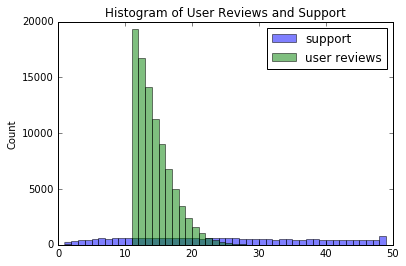

In [44]:
plt.hist(s, bins=np.arange(1,50,1), alpha=0.5, label="support");
c=smalldf.groupby('user').artist.count()
print "User-artists counts mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(1,50,1), alpha=0.5, label="user reviews");
plt.legend();
plt.ylabel("Count")
plt.title("Histogram of User Reviews and Support")
plt.show()

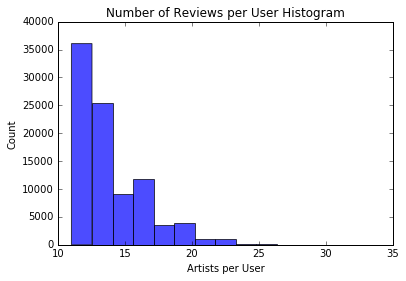

In [45]:
plt.hist(smalldf.groupby('user').count().user_artist_count,bins=15,alpha=0.7)
plt.xlabel("Artists per User")
plt.ylabel("Count")
plt.title("Number of Reviews per User Histogram")
plt.show()

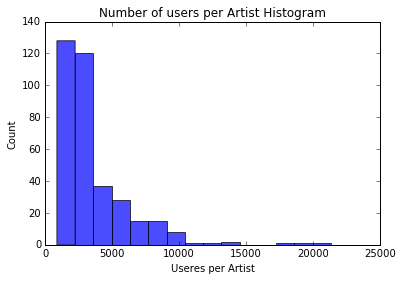

In [46]:
plt.hist(smalldf.groupby('artist').count().artist_user_count,bins=15,alpha=0.7)
plt.xlabel("Useres per Artist")
plt.ylabel("Count")
plt.title("Number of users per Artist Histogram")
plt.show()

In [ ]:
###